In [19]:
using Revise  # auto reload

includet("State_Space_Model.jl")
using .state_space_model

includet("Kalman.jl")
using .kalman

includet("MCMC.jl")
using .MCMC

using Random
using LinearAlgebra
using Statistics
using Distributions
using ProgressMeter
using SpecialFunctions
using Plots


In [20]:
# Parameters in θ
θ_elements = ["ρ", "λ_c", "σ²_ε, y", "σ²_ξ, y", "σ²_κ, y"]
n_params = length(θ_elements)

# Create the support matrix
support = [
    0.0 1.0;  # ρ
    0.0 3.0;  # λ_c
    0.0 Inf;  # σ²_ε, y
    0.0 Inf;  # σ²_ξ, y
    0.0 Inf  # σ²_κ, y
]

# Create the prior distributions
prior_distributions = (
    "uniform",  # ρ
    "uniform",  # λ_c
    "uniform",  # σ²_ε, y
    "uniform",  # σ²_ξ, y 
    "uniform",  # σ²_κ, y
)

# Create the prior hyperparameters matrix
prior_hyperparameters = [
    0.0 1.0;  # ρ
    0.0 3.0;  # λ_c
    0.0 1.0;  # σ²_ε, y
    0.0 1.0;  # σ²_ξ, y
    0.0 1.0  # σ²_κ, y
]

# Combine into a named tuple
prior_info = (
    support = support,
    distributions = prior_distributions,
    parameters = prior_hyperparameters,
)


# True parameters
ρ = 0.5
λ_c = 0.1
σ²_ε_y = 4*10e-5
σ²_ξ_y = 4*10e-6
σ²_κ_y = 6*10e-5

θ_true = [ρ, λ_c, σ²_ε_y, σ²_ξ_y, σ²_κ_y]

# cycle_order
cycle_order = 2


#States in α
α_elements = [
    "u_t^y", 
    "β_t^y", 
    "ψ_{2,t}^y", 
    "ψ_{2,t}^{y*}", 
    "ψ_{1,t}^y", 
    "ψ_{1,t}^{y*}", 
]

6-element Vector{String}:
 "u_t^y"
 "β_t^y"
 "ψ_{2,t}^y"
 "ψ_{2,t}^{y*}"
 "ψ_{1,t}^y"
 "ψ_{1,t}^{y*}"

In [21]:
Z,H,T,R,Q,P_diffuse = state_space(θ_true, cycle_order,1)
println("Z = ", Z)
println("H = ", H)
println("T = ", T)
println("R = ", R)
println("Q = ", Q)
println("P_diffuse = ", P_diffuse)

# Print shapes
println("Z shape: ", size(Z))
println("H shape: ", size(H))
println("T shape: ", size(T))
println("R shape: ", size(R))
println("Q shape: ", size(Q))
println("P_diffuse shape: ", size(P_diffuse))

Z = [1.0 0.0 1.0 0.0 0.0 0.0]
H = [0.0004]
T = [1.0 1.0 0.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.4975020826390129 0.04991670832341408 1.0 0.0; 0.0 0.0 -0.04991670832341408 0.4975020826390129 0.0 1.0; 0.0 0.0 0.0 0.0 0.4975020826390129 0.04991670832341408; 0.0 0.0 0.0 0.0 -0.04991670832341408 0.4975020826390129]
R = [0.0 0.0 0.0; 1.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
Q = [4.0e-5 0.0 0.0; 0.0 0.0006000000000000001 0.0; 0.0 0.0 0.0006000000000000001]
P_diffuse = [1.0 0.0 0.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0]
Z shape: (1, 6)
H shape: (1,)
T shape: (6, 6)
R shape: (6, 3)
Q shape: (3, 3)
P_diffuse shape: (6, 6)


shape of obs_std = (1, 300)
shape of obs = (1, 300)


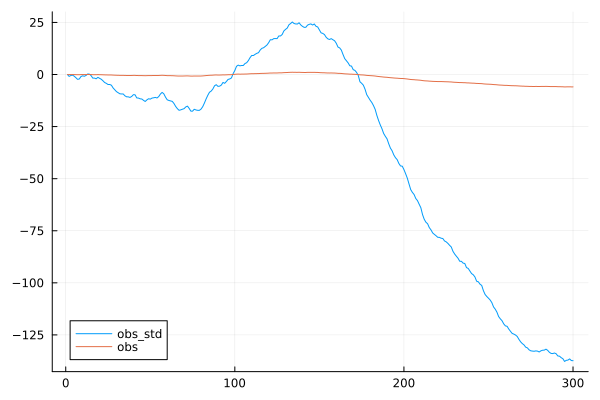

6×6 Matrix{Bool}:
 1  0  0  0  0  0
 0  1  0  0  0  0
 0  0  1  0  0  0
 0  0  0  1  0  0
 0  0  0  0  1  0
 0  0  0  0  0  1

In [22]:
n_obs = 300

#simulate data
obs, α = simulate_data(θ_true, cycle_order, n_obs)
obs_std, σʸ = standardize_data(obs)
println("shape of obs_std = ", size(obs_std))
println("shape of obs = ", size(obs))

σʸ = σʸ[1]

y = obs_std


# plot obs_std and obs
plot(obs_std[1,:], label="obs_std")
plot!(obs[1,:], label="obs")
display(plot!())

α0 = zeros(size(T, 1))
P0 = Matrix(I, size(T, 1), size(T, 1))  # large initial uncertainty



## MCMC

In [25]:
θ_0 = [0.2, 0.3, 0.2, 0.01, 0.2]

θ_chain, θ_chain_init, α_draws = MCMC_estimation(y, prior_info, α0, P0, cycle_order, σʸ;
 iter_init = 25000, 
 burn_init = 15000,
 iter_rec = 25000,
burn_rec = 15000,
θ_init = θ_0,
ω = 0.01)

Initialization Phase 100%|███████████████████████████████| Time: 0:00:30


Initialization Acceptance Rate: 30.676%


Recursion Phase 100%|████████████████████████████████████| Time: 0:01:02


Recursion Acceptance Rate: 31.028%


([0.5066024976864189 0.08409640782636199 … 3.0196294813066405e-5 0.0005405154722561783; 0.5066024976864189 0.08409640782636199 … 3.0196294813066405e-5 0.0005405154722561783; … ; 0.6117402100717786 0.1592258425061702 … 3.5943124555469845e-5 0.0003758327848125008; 0.6117402100717786 0.1592258425061702 … 3.5943124555469845e-5 0.0003758327848125008], [0.1954174220596734 0.3003485328875971 … 0.010628125539637807 0.1983917448284688; 0.1954174220596734 0.3003485328875971 … 0.010628125539637807 0.1983917448284688; … ; 0.5812751132237874 0.0965870033338621 … 3.624551203525986e-5 0.0004786869534413958; 0.5812751132237874 0.0965870033338621 … 3.624551203525986e-5 0.0004786869534413958], [-0.14855378277169484 0.00020062786998409354 … 0.041481376047109 0.7227546649477328; -0.03302704092457298 0.013620384396220708 … -0.0497236541018897 0.23192152527762863; … ; -0.10722859953314723 -0.0007868337397471947 … -0.020571302323699747 0.13500733058377223; -0.22815394087442137 0.010845277953786203 … 0.187508

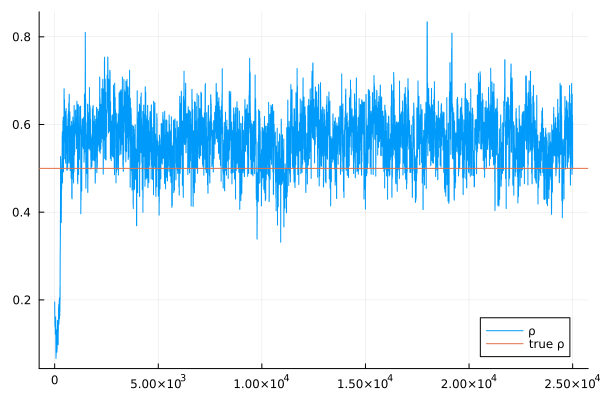

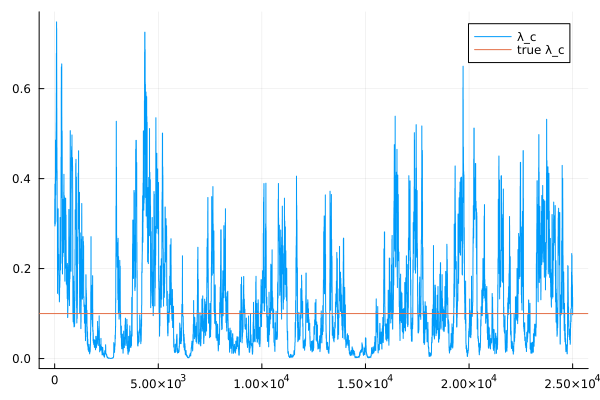

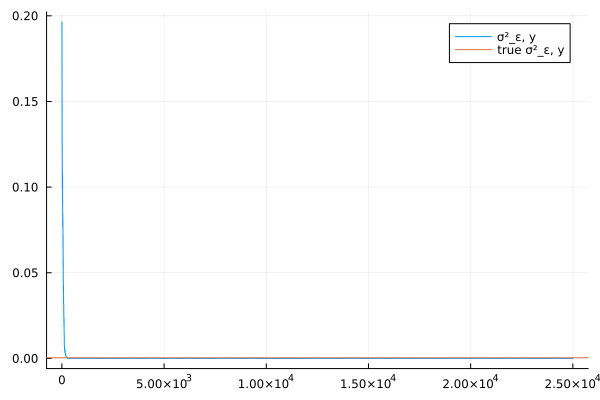

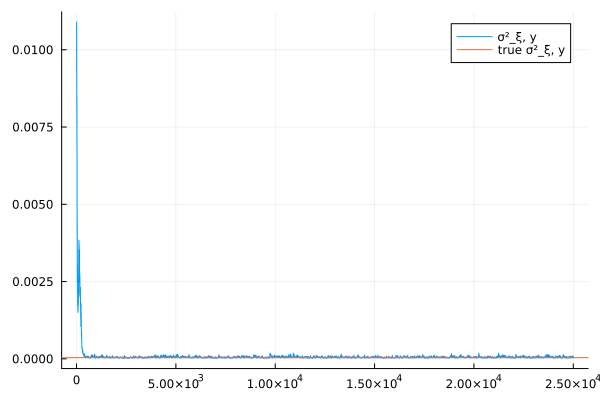

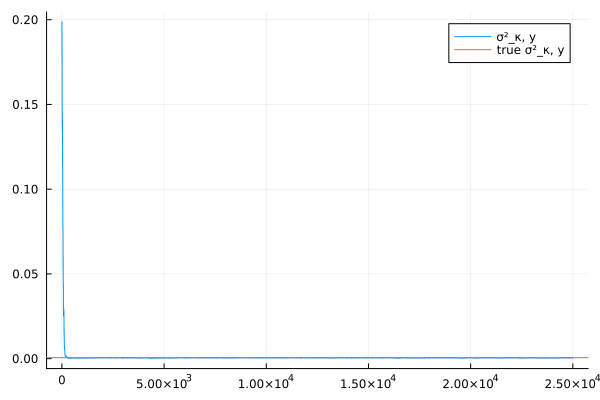

Initial chain shape: (25000, 5)


In [14]:
println("Initial chain shape: ", size(θ_chain_init))
#Print trace plot and add true value
for i in 1:size(θ_chain_init, 2)
    plot(θ_chain_init[:,i], label="$(θ_elements[i])")
    hline!([θ_true[i]], label="true $(θ_elements[i])")
    display(plot!())
end

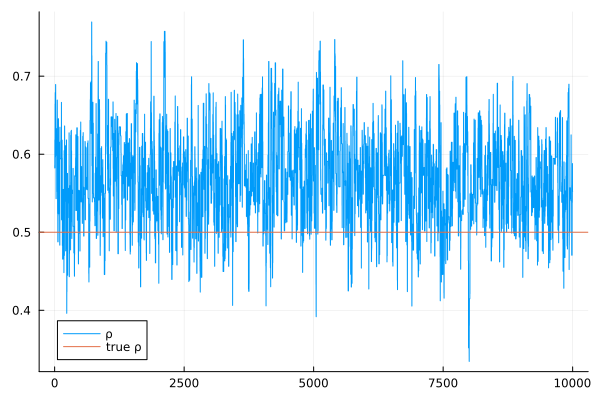

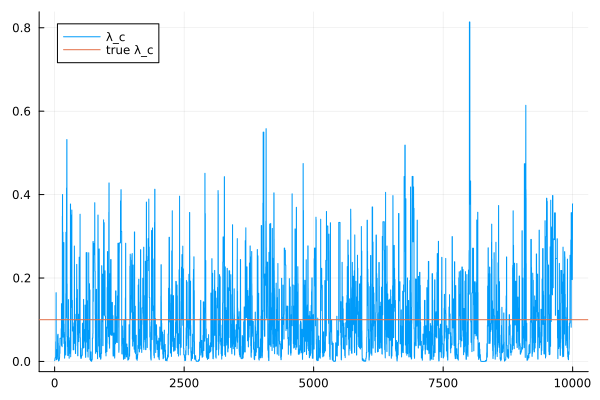

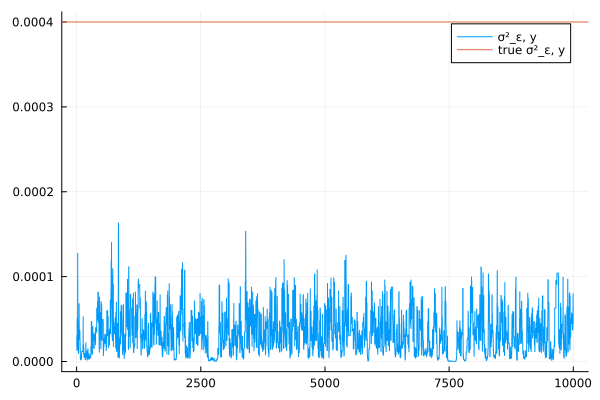

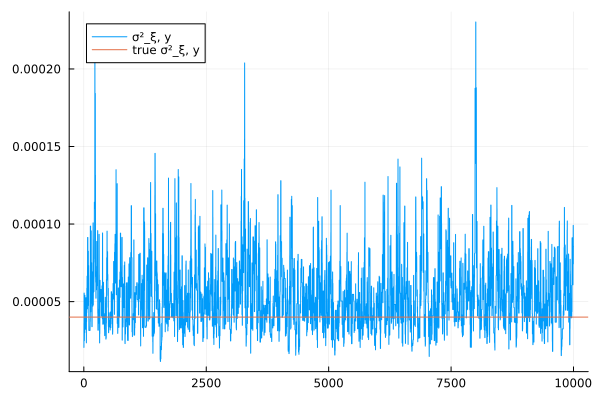

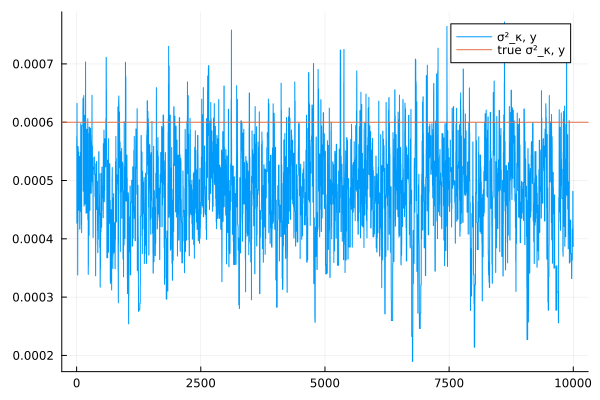

Rec chain shape: (10000, 5)


In [15]:
println("Rec chain shape: ", size(θ_chain))

#Print trace plot and add true value
for i in 1:size(θ_chain, 2)
    plot(θ_chain[:,i], label="$(θ_elements[i])")
    hline!([θ_true[i]], label="true $(θ_elements[i])")
    display(plot!())
end



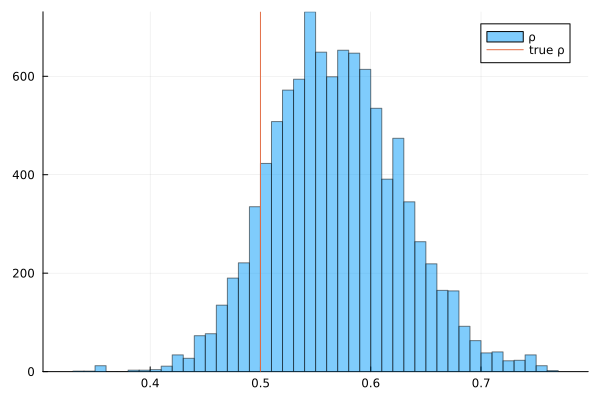

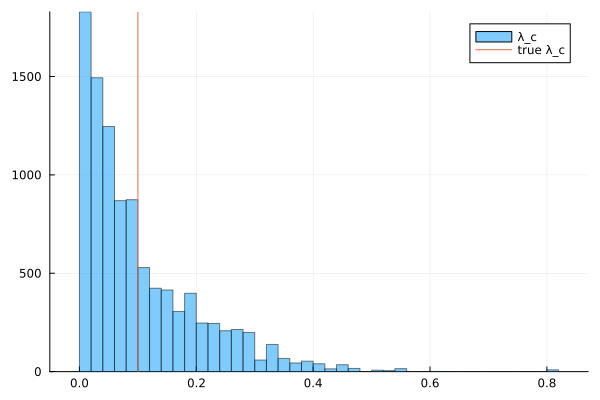

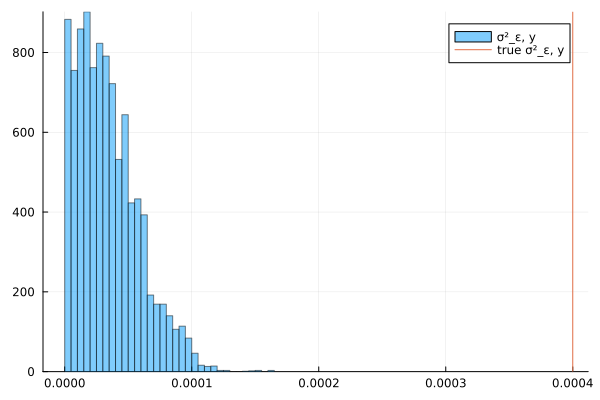

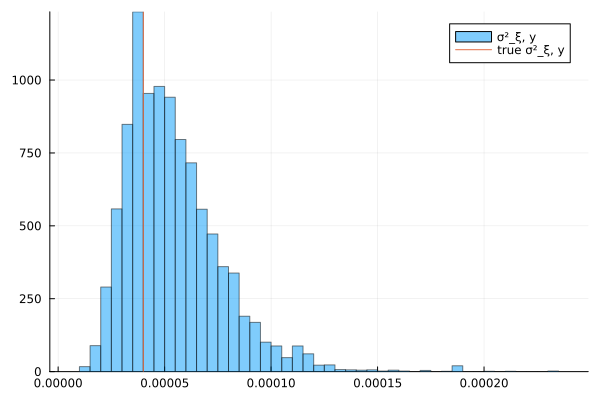

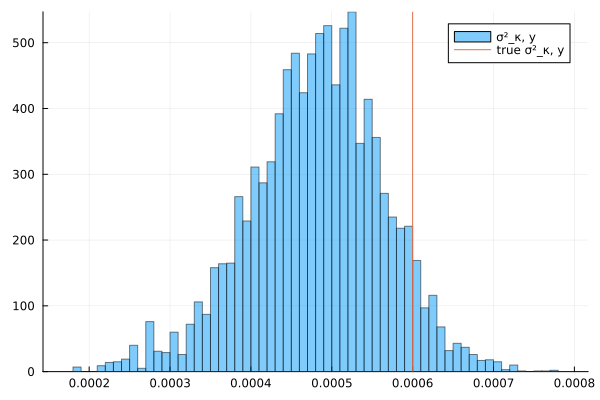

In [16]:
# plot histograms of the chains and add line at true value
for i in 1:size(θ_chain, 2)
    histogram(θ_chain[:,i], label="$(θ_elements[i])", alpha=0.5)
    vline!([θ_true[i]], label="true $(θ_elements[i])")
    display(plot!())
end

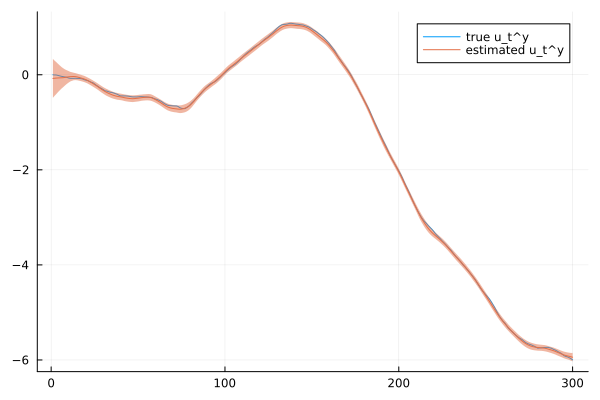

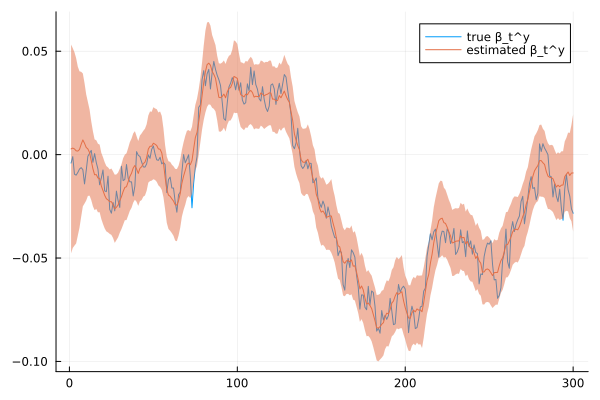

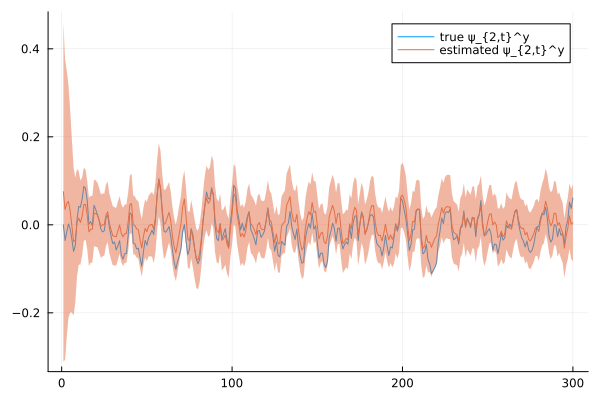

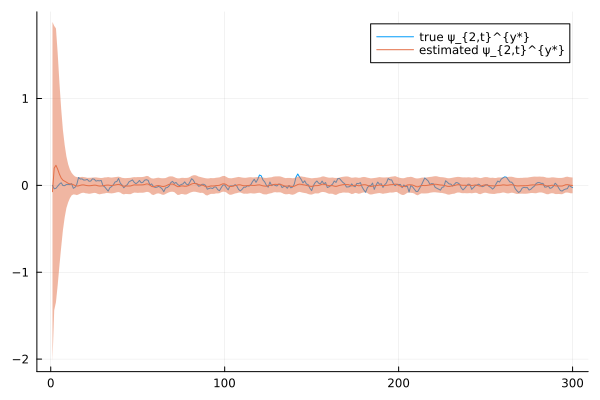

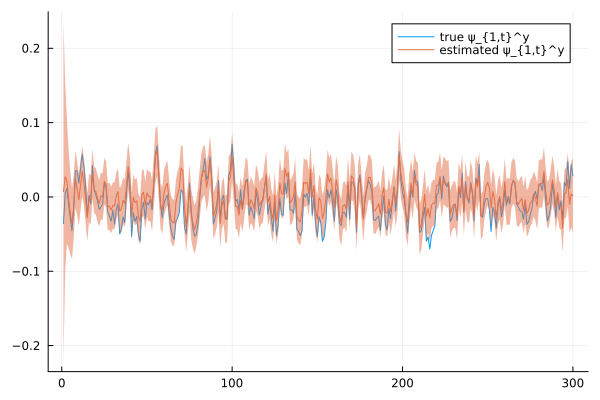

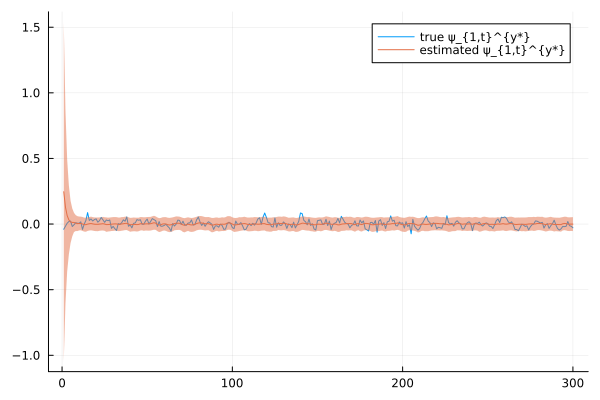

Mean of α_draws: (1, 6, 300)


In [9]:
# Compute the mean over iterations (dimension 1)
α_mean = mean(α_draws, dims=1)
println("Mean of α_draws: ", size(α_mean))

# Compute the 2.5% and 97.5% quantiles 
α_ci = mapslices(x -> quantile(x, [0.025, 0.975]), α_draws, dims=1)



# Plot true states, mean of states, and confidence intervals of states
for i in 1:size(α_mean, 2)
    plot(α[i, :], label="true $(α_elements[i])")
    plot!(α_mean[1, i, :], ribbon=(α_ci[2, i, :] .- α_mean[1, i, :]), label="estimated $(α_elements[i])")
    display(plot!())
end


## MLE

In [10]:
# using Optim


# lower_bounds = [0.0, 0.0, 1e-12, 1e-12, 1e-12]
# upper_bounds = [1.0, 3.0, 3.0, 3.0, 3.0]
# θ_init = [0.5, 0.1, 4*10e-5, 4*10e-6, 6*10e-5]

# objective(θ) = neg_log_likelihood(θ, y, α0, P0, cycle_order, σʸ)
# res = optimize(objective, lower_bounds, upper_bounds, θ_init, Fminbox(BFGS()))
# θ_est = Optim.minimizer(res)

# # Print the results:
# println("MLE Results (with bounded optimization):")
# for (i, param_name) in enumerate(θ_elements)
#     println("Estimated $(param_name): $(θ_est[i])   (True value: $(θ_true[i]))")
# end
# println("Final negative log-likelihood: ", Optim.minimum(res))


In [11]:
# # estimate states
# LogL_diff, α_diff, P_diff = diffuse_kalman_filter(y, θ_est, α0, P0, cycle_order, σʸ,  true, false)

# #plot estimated states and true states
# for i in 1:size(α,2)
#     plot(α[:,i], label="true $(α_elements[i])")
#     plot!(α_diff[:,i], label="estimated $(α_elements[i])")
#     display(plot!())
# end

